<a href="https://colab.research.google.com/github/heitorabqg/datascientist/blob/master/HA_prob_divergencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

lambda_max (estimada) = 0.9805, mu_teo = 2/lambda_max = 2.039877


/tmp/ipython-input-38442161.py:63: RuntimeWarning: overflow encountered in square
  mse = np.cumsum(e**2) / (np.arange(1, N+1))  # média acumulada (opcional)
/tmp/ipython-input-38442161.py:64: RuntimeWarning: overflow encountered in square
  ss_mse = np.mean(e[-K:]**2)  # steady-state MSE estimado
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/tmp/ipython-input-38442161.py:44: RuntimeWarning: overflow encountered in scalar multiply
  w = w + 2 * mu * e[n] * xn
/tmp/ipython-input-38442161.py:44: RuntimeWarning: invalid value encountered in add
  w = w + 2 * mu * e[n] * xn
/tmp/ipython-input-38442161.py:44: RuntimeWarning: overflow encountered in multiply
  w = w + 2 * mu * e[n] * xn
/tmp/ipython-input-38442161.py:42: RuntimeWarning: invalid value encountered in matmul
  y = w @ xn
/tmp/ipython-input-38442161.py:42: RuntimeWarning: overflow encountered in matmul
  y = w @ xn
/tmp/ipy

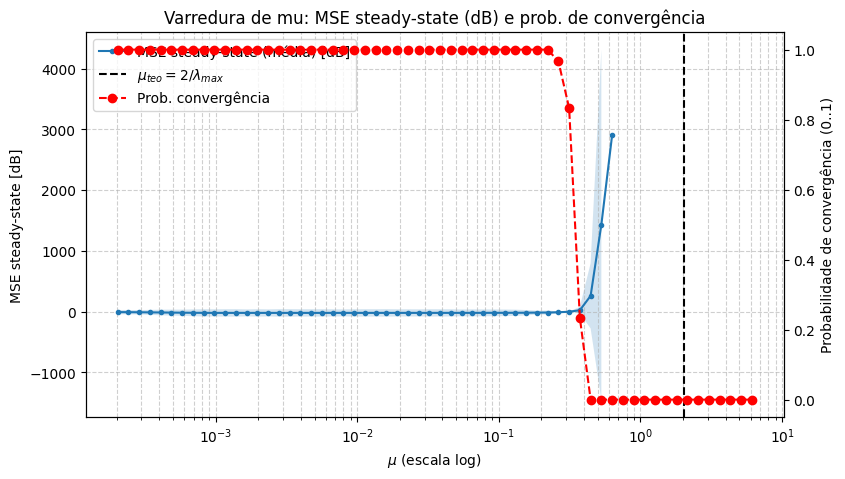

mu crítico empírico (prob_converge < 0.9) ≈ 3.138392e-01


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Parâmetros do experimento (ajuste conforme seu caso) ----------
np.random.seed(0)
w_true = np.array([0.5, -0.8])   # sistema verdadeiro (2 coeficientes)
N = 2000                         # número de amostras por trial
num_mu = 60                      # quantos mu testar
num_trials = 30                  # quantos trials por mu
noise_std = 0.1                  # ruído de saída
mu_factor_range = (1e-4, 3.0)    # faixa relativa (multiplicativa) para explorar em relação a mu_teo

# Gera um bloco de dados para estimar R e depois novos dados por trial
# Aqui uso entradas gaussianas iid; adapte para seu caso
X_block = np.random.randn(2, 5000)
d_block = w_true @ X_block + noise_std * np.random.randn(X_block.shape[1])

# Estima R
R_hat = (X_block @ X_block.T) / X_block.shape[1]
eigs = np.linalg.eigvalsh(R_hat)
lambda_max = np.max(eigs)
mu_teo = 2.0 / lambda_max
print(f"lambda_max (estimada) = {lambda_max:.4f}, mu_teo = 2/lambda_max = {mu_teo:.6f}")

# Grade de mu (usar escala log para cobrir várias ordens de grandeza)
mu_vals = np.logspace(np.log10(mu_teo*mu_factor_range[0]),
                      np.log10(mu_teo*mu_factor_range[1]),
                      num=num_mu)

# Função LMS (stocástico) que retorna vetor de erros e pesos ao longo do tempo
def run_lms(x, d, mu, w0=None):
    M, N = x.shape
    if w0 is None:
        w = np.zeros(M)
    else:
        w = w0.copy()
    e = np.zeros(N)
    W = np.zeros((N+1, M))
    W[0] = w
    for n in range(N):
        xn = x[:, n]
        y = w @ xn
        e[n] = d[n] - y
        w = w + 2 * mu * e[n] * xn
        W[n+1] = w
    return e, W

# Critério de divergência:
# - Diverge se MSE final (média das últimas K iterações) > threshold_factor * var_ruido
# - ou se MSE contém NaN/Inf
threshold_factor = 100.0
K = 200  # últimas K iterações para estimar steady-state

mse_steady_avg = np.zeros((len(mu_vals), num_trials))
diverged = np.zeros((len(mu_vals), num_trials), dtype=bool)

for i_mu, mu in enumerate(mu_vals):
    for t in range(num_trials):
        # gera dados novos para o trial
        x = np.random.randn(2, N)
        d = w_true @ x + noise_std * np.random.randn(N)
        e, W = run_lms(x, d, mu)
        mse = np.cumsum(e**2) / (np.arange(1, N+1))  # média acumulada (opcional)
        ss_mse = np.mean(e[-K:]**2)  # steady-state MSE estimado
        mse_steady_avg[i_mu, t] = ss_mse
        # condição de divergência
        if not np.isfinite(ss_mse) or ss_mse > threshold_factor * (noise_std**2):
            diverged[i_mu, t] = True

# Estatísticas por mu
prob_converge = 1.0 - diverged.mean(axis=1)    # probabilidade de convergência
mse_mean = 10*np.log10(np.mean(mse_steady_avg, axis=1) + 1e-15)
mse_std = 10*np.log10(np.std(mse_steady_avg, axis=1) + 1e-15)

# Plot: MSE steady-state (dB) vs mu (log-scale), com probabilidade de convergência
fig, ax1 = plt.subplots(figsize=(9,5))

ax1.plot(mu_vals, mse_mean, '.-', label='MSE steady-state (média) [dB]')
ax1.fill_between(mu_vals, mse_mean - 2*np.abs(mse_std), mse_mean + 2*np.abs(mse_std), alpha=0.2)
ax1.set_xscale('log')
ax1.set_xlabel(r'$\mu$ (escala log)')
ax1.set_ylabel('MSE steady-state [dB]')
ax1.grid(True, which='both', ls='--', alpha=0.6)
ax1.axvline(mu_teo, color='k', linestyle='--', label=r'$\mu_{teo}=2/\lambda_{max}$')

ax2 = ax1.twinx()
ax2.plot(mu_vals, prob_converge, 'r--o', label='Prob. convergência')
ax2.set_ylabel('Probabilidade de convergência (0..1)')
ax2.set_ylim([-0.05, 1.05])

# legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc='best')

plt.title('Varredura de mu: MSE steady-state (dB) e prob. de convergência')
plt.show()

# Encontra o mu crítico empírico (ex.: menor mu com prob_converge < 0.9)
crit_idx = np.where(prob_converge < 0.9)[0]
if crit_idx.size > 0:
    mu_crit_emp = mu_vals[crit_idx[0]]
    print(f"mu crítico empírico (prob_converge < 0.9) ≈ {mu_crit_emp:.6e}")
else:
    print("Nenhum mu na grade fez prob_converge < 0.9 (experimento).")
